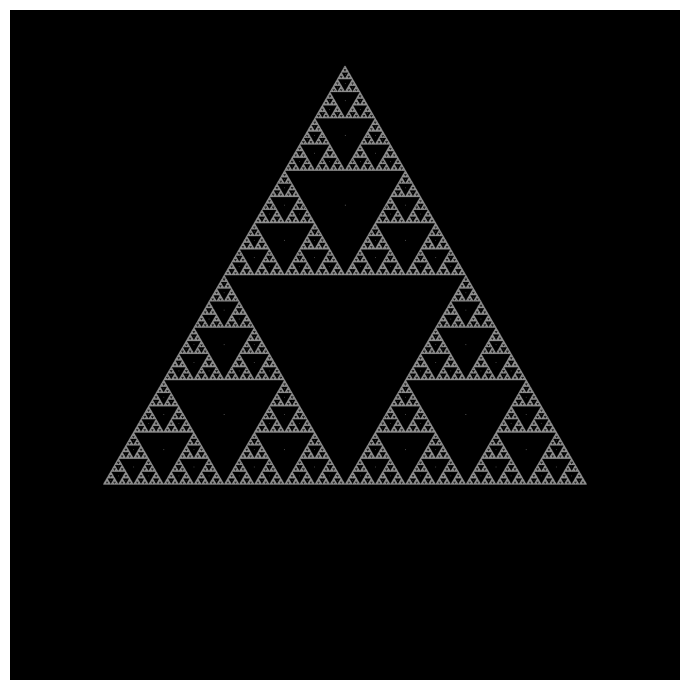

In [9]:
# Task 3.2: Fractal Implementation
# Sierpiński triangle in PyTorch
"""
Prompts:
- In PyTorch, create an equalateral triangle
- Translate each point in the tensor by a chosen set of indicies
- Map the x and y coordinates of my dots onto an image and ensure it's centered
"""
import math
import torch
import matplotlib.pyplot as plt

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

"""
How Sierpiński triangle is created:
Step 1: Start with a triangle, defined by 3 point. 
Step 2: Randomly pick one of the vertices, then move a point (or many points - however you define it) halway towards it.
Step 3: Repeat the process. Eventually the Sierpiński triangle is created.
Step 4: Stop when the maximum depth is reached.
"""

# --- Step 1: Define the Equilateral triangle ---
R = 1.0  # size of the triangle

# Coordinates for the vertices 
V = torch.tensor([
    [0.0,  R],                                  # top corner of the triangle V[0] = [cos 90, sin 90]
    [-math.sqrt(3)/2 * R, -0.5 * R],            # bottom-left corner V[1] = [cos 210, sin 210] - each corner is 120 degrees apart
    [ math.sqrt(3)/2 * R, -0.5 * R],            # bottom-right corner v[2] = [cos 330, sin 330]
], device=device)

# --- Rendering Configuration ---
W = H = 1200        # size of the canvas
batch = 200_000     # number of point we move each iteration
iters = 200         # total moves we make (more = sharper image)
extent = 1.2        # how far our "camera" looks around the origin

# --- Blank Canvas ---
# Makes a blank canvas with H height and W width
img = torch.zeros((H, W), device=device)

# Initalise all your points that you will use to build the fractal later at the origin (it doesn’t matter where, chaos game will converge eventually).
# '2' is how many columns we have so every point looks like [x, y]
# Device is where we store the tensor
xy = torch.zeros(batch, 2, device=device)

# --- Chaos game loop  ---
for i in range(iters):
    # chooses a random int from 0 (inclusive) to 3 (exclusive) for each dot in the batch (200,000 dots)
    # 0 = top vertex, 1 = bottom-left vertex, 2 = bottom-right vertex
    # Returns an index tensor - an array of integers, with each int corresponding to the vertext that dot moves to
    idx = torch.randint(0, 3, (batch,), device=device)

    # move each particle halfway toward that chosen vertex
    # this simple "rule" is what makes the Sierpiński triangle appear
    # xy is current position of all dots - initialised at 0
    # V[idx] returns a list of coordinates chosen by each dot.
    # Adding two tensors does element-wise addition: xy + V[idx] = adds the dot’s position to its chosen corner. This shifts each dot to the randomly chosen points.
    # 0.5 * (…) = takes the midpoint between the dot and the vertex
    xy = 0.5 * (xy + V[idx])
    
    # rescale x,y from triangle coords → pixel coords (so they fit our image)
    # take all the x-coordinates of the dots: 'xy[:, 0]'
    # Scale those x-values down by the full width of your “camera box.”: '/ (2*extent)'
    # Shift everything up so the range becomes [0, 1]: '+ 0.5'
    # Clamp ensures the values stay within a given range: tensor.clamp(min, max) - Anything smaller than min becomes min. Anything bigger than max becomes max.
    xn = (xy[:, 0] / (2*extent) + 0.5).clamp(0, 0.999999)
    yn = (xy[:, 1] / (2*extent) + 0.5).clamp(0, 0.999999)

    # turn normalized coords into actual pixel indices
    # .long() converts a tensor into 64-bit integers to ensure dot coordinates turn into valid pixel addresses.
    xi = (xn * W).long()
    yi = (yn * H).long()

    # flatten (x,y) pixel coordinates into a single 1D index
    flat = yi * W + xi
    
    # count how many times each pixel index appears (i.e. how many dots landed there)
    # minlength=W*H ensures we have a count for every pixel in the image
    counts = torch.bincount(flat, minlength=W*H)

    # reshape the 1D counts back into a 2D image grid
    img += counts.view(H, W)

# --- Display the result ---
imf = torch.log1p(img.float())             # apply log so faint points are still visible
plt.figure(figsize=(7,7)); plt.axis('off') # hide axes, square image
plt.imshow(imf.cpu(), cmap='gray', origin='lower')  # draw the fractal
plt.tight_layout(); plt.show()
